# **DELE CA1 Part B**

Name: Lim Zhen Yang

Admission Number: 2214506

Class: DAAA/FT/2B/04


# **IMPORTS**


In [6]:
import os
import string
import math
import nltk
import numpy as np
import pandas as pd
import random
import keras as K
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.activations import softmax
from keras.layers import (
    Embedding,
    Reshape,
    Input,
    SimpleRNN,
    Dense,
    LSTM,
    GRU,
    Dropout,
    Bidirectional,
    TextVectorization,
    MultiHeadAttention,
    LayerNormalization,
    Layer,
)
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
    LearningRateScheduler,
)
from keras_tuner import RandomSearch
import keras.optimizers as optimizers
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.model_selection import train_test_split

Check and limit GPU usage


In [297]:
# Check if TensorFlow can access GPUs
if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
else:
    print("No GPU devices found. TensorFlow will use CPU.")

No GPU devices found. TensorFlow will use CPU.


# **BACKGROUND RESEARCH**

### Breakthroughs in NLP

1990s: Sepp Hochreiter and Jurgen Schmidhuber's introduction of Long Short-Term Memory (LSTM) networks addressed limitations in RNNs, significantly enhancing the AI's ability to analyze longer text sequences (TechTarget, 2023).

2000s: Landmark papers by teams including those at Bell Communications and the University of Montreal introduced techniques like Latent Semantic Analysis and neural probabilistic language models, setting the stage for current deep learning approaches (TechTarget, 2023).

2010s: The advent of transformer models, particularly Google's development of the "Attention is all you need" paper and BERT (Bidirectional Encoder Representations from Transformers), revolutionized text generation, offering better context understanding and efficiency (TechTarget, 2023).

OpenAI's GPT Series: Starting with GPT in 2018, followed by more advanced versions like GPT-3 and GPT-4, these models have become the cornerstone of modern text generation, with applications in generating coherent and contextually relevant text (TechTarget, 2023).

Reference:

TechTarget. (2023). History of generative AI innovations spans 9 decades. Retrieved from https://www.techtarget.com/searchenterpriseai/tip/History-of-generative-AI-innovations-spans-9-decades

### Limitations of Text Generation

Lack of contextual understanding: Text generation models often struggle with comprehending the broader context and nuances of language. They generate text based on patterns in the training data without truly understanding the meaning or intent behind the words. This can lead to inaccuracies, ambiguity, or nonsensical outputs (DataCamp, 2023).

Overreliance on training data: Text generation models heavily rely on the quality and diversity of the training data they are exposed to. If the training data is limited, biased, or doesn't represent the full range of language variations, the generated text may be biased, lack diversity, or exhibit other shortcomings (DataCamp, 2023).

Difficulty in handling rare or unseen scenarios: Text generation models may struggle when faced with uncommon or rare scenarios that were not well-represented in the training data. They may produce incorrect or nonsensical responses when encountering unfamiliar or out-of-context inputs (DataCamp, 2023).

Ethical considerations: Text generation raises ethical concerns, particularly in relation to misinformation, propaganda, or generating harmful content. If not carefully monitored and guided, text generation models can be misused to spread misinformation, amplify biases, or engage in malicious activities (DataCamp, 2023).

Reference:

DataCamp. (2023). What Is Text Generation? [Blog post]. Retrieved from https://www.datacamp.com/blog/what-is-text-generation

# **EXPLORATORY DATA ANALYSIS**


Reading dataset with `pd.read_csv()`

In [298]:
import pandas as pd

train_csv = pd.read_csv("./train.csv")
train_csv.head()

,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."


Checking for null values
> There are no null values

In [299]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Quotes  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


Generating descriptive statistics
1. There are 1000 datapoints
2. 890 of them are unique indicating there are duplicated quotes
3. The most repeated quote was repeated 5 times

Repeated text data can introduce **bias** into the model. If certain phrases or sentences are overrepresented due to repetition, the model might learn to favor them and generate similar outputs excessively.

I want my text generation model to produce diverse and creative outputs, thus removing repeated data can be beneficial.

FInally, removing repeated data can reduce the training time since the model won't have to process the same text multiple times.

Thus I will be **removing** repeated quotes

In [300]:
train_csv.describe()

,Quotes
count,1000
unique,890
top,"Radiate acceptance, and find peace in embracin..."
freq,5


### **Length of quotes**
Most quotes have around 68.94 words which tells me that my model does not need extremely long memory to generate good predictions because shorter quotes are preferable.

Number of quotes: 1000
Average quote length: 68.94 words


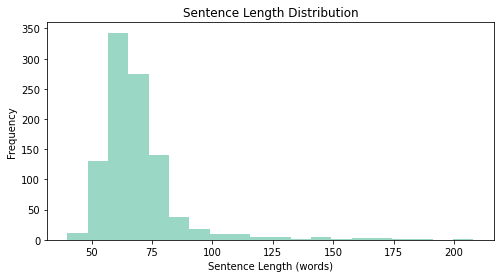

In [301]:
num_quotes = len(train_csv)
sentence_lengths = train_csv["Quotes"].apply(lambda x: len(x))
avg_quote_length = sentence_lengths.mean()
print(f"Number of quotes: {num_quotes}")
print(f"Average quote length: {avg_quote_length:.2f} words")

plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=20, alpha=0.7, color="#6fc6ab")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.show()

### **Word Frequency Analysis**
The distribution of word and phrase frequencies follows common linguistic patterns e.g. `the` is the most commonly used word in this dataset and in the whole english corpus.

Therefore this dataset reflects real world use cases and frequencies.

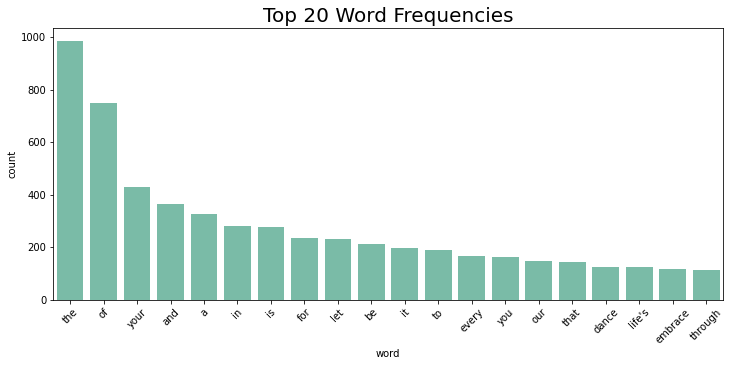

In [302]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_csv["Quotes"])

word_count = pd.DataFrame(tokenizer.word_counts.items(), columns=["word", "count"])
top_20_word_counts = word_count.sort_values("count", ascending=False)[:20]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Top 20 Word Frequencies", fontsize=20)
ax.tick_params(axis="x", rotation=45)

sns.barplot(
    x=top_20_word_counts["word"],
    y=top_20_word_counts["count"],
    ax=ax,
    color="#6fc6ab",
)
plt.show()

The least common words occur only once in the whole dataset. The lack of examples for these words will make it difficult for the model to preidct them. We can make use of data augmentation to help.

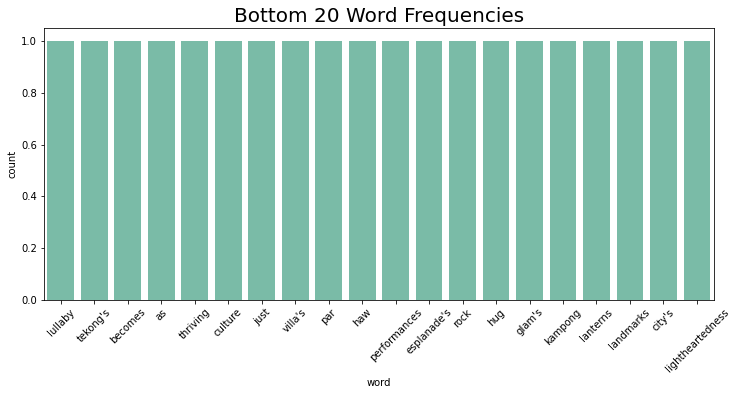

In [303]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_csv["Quotes"])

word_count = pd.DataFrame(tokenizer.word_counts.items(), columns=["word", "count"])
bottom_20_word_counts = word_count.sort_values("count", ascending=False)[-20:]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Bottom 20 Word Frequencies", fontsize=20)
ax.tick_params(axis="x", rotation=45)

sns.barplot(
    x=bottom_20_word_counts["word"],
    y=bottom_20_word_counts["count"],
    ax=ax,
    color="#6fc6ab",
)
plt.show()

### **N-gram Analysis**
Certain phrases like "morning let" are particularly prevalent.

The data seems to frequently include references to locations or themes consistent with Singapore ("lion city", "singapore skyline", "singapore nature"). In these cases, we can create additional tokens by combining words frequently found together, phrase chunking.

In [304]:
# Function to extract n-grams
def get_top_ngrams(corpus, n=None, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]


# Extracting bigrams
top_bigrams = get_top_ngrams(train_csv["Quotes"], 2, 10)

# Extracting trigrams
top_trigrams = get_top_ngrams(train_csv["Quotes"], 3, 10)

# Convert the results into DataFrames
df_bigrams = pd.DataFrame(top_bigrams, columns=["Bigram", "Frequency"])
df_trigrams = pd.DataFrame(top_trigrams, columns=["Trigram", "Frequency"])

# Combine DataFrames side by side with a gap in the middle
combined_df = pd.concat([df_bigrams, df_trigrams], axis=1)

# Print the combined DataFrame
combined_df

,Bigram,Frequency,Trigram,Frequency
0,morning let,52,morning let actions,13
1,embrace power,25,heart lion city,11
2,let heart,21,morning let kindness,11
3,let kindness,20,let heart lead,8
4,let actions,17,heart lead way,8
5,life garden,15,life garden flourishes,8
6,dance symphony,15,dance chapters growth,8
7,lion city,15,tapestry woven threads,6
8,singapore skyline,15,singapore nature sanctuary,6
9,singapore nature,15,morning let gratitude,6


# **DATA PREPARATION**

Punctuation is very important in quotes. Conventionally, tokenizers filter our special characters. However I am going to keep them as our model has to learn when to punctuate as well.

In [305]:
# Convert df to a list
data = list(train_csv["Quotes"].values)

To make sure that the punctuation is recognized as its own token, we need a seperator between the word and the punctuation. A naive approach is to replace the punctuation in the text with a space + punctuation.

If you tokenize the example sentence the result would take "cold." as a token instead of "cold" and ".". 

In [306]:
import string

def add_space_before_punctuation(data):
    clean_data = []
    for text in data:
        for char in string.punctuation:
            text = text.replace(char, f' {char}')
        clean_data.append(text)
    return clean_data


clean_data = add_space_before_punctuation(data)

### **Tokenization**


In [307]:
# Tokenisation.
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='')  # Instantiate a Tokenizer object.
tokenizer.fit_on_texts(clean_data)  # Fit your Tokenizer on the dataset

tokenizer.word_index

{'.': 1,
 'the': 2,
 'of': 3,
 ',': 4,
 'your': 5,
 'and': 6,
 'a': 7,
 "'s": 8,
 'in': 9,
 'is': 10,
 'for': 11,
 'let': 12,
 'be': 13,
 'it': 14,
 'to': 15,
 'life': 16,
 'every': 17,
 'you': 18,
 'our': 19,
 'that': 20,
 'dance': 21,
 'embrace': 22,
 'through': 23,
 'this': 24,
 'with': 25,
 'believe': 26,
 'are': 27,
 'radiate': 28,
 'yourself': 29,
 'morning': 30,
 'heart': 31,
 'planet': 32,
 'singapore': 33,
 'will': 34,
 'they': 35,
 'love': 36,
 'kindness': 37,
 'dreams': 38,
 'symphony': 39,
 'we': 40,
 'power': 41,
 'from': 42,
 'soul': 43,
 ';': 44,
 'find': 45,
 'world': 46,
 'gratitude': 47,
 'light': 48,
 'act': 49,
 'nature': 50,
 'journey': 51,
 'strength': 52,
 'joy': 53,
 'beauty': 54,
 'way': 55,
 'canvas': 56,
 'colors': 57,
 'whispers': 58,
 'hope': 59,
 'spirit': 60,
 'where': 61,
 'potential': 62,
 'resilience': 63,
 'beacon': 64,
 'testament': 65,
 'true': 66,
 'towards': 67,
 'hold': 68,
 'future': 69,
 'compassion': 70,
 'hearts': 71,
 'garden': 72,
 'step': 

In [308]:
VOCABULARY_LEN = len(tokenizer.word_index) + 1  # 0 reserved for padding

**Texts to sequence of integers / tokens**


In [309]:
tokenized_sequences = []

for datapoint in data:
    token_list = tokenizer.texts_to_sequences([datapoint])[0]
    tokenized_sequences.append(token_list)

print(
    f"Total number of quotes converted from texts to integers: {len(tokenized_sequences)}"
)
tokenized_sequences[:][:10]

Total number of quotes converted from texts to integers: 1000


[[22, 2, 54, 3, 17, 7, 183, 518, 15, 111, 5, 46, 25],
 [22, 35, 27, 2, 411, 519, 15, 5, 412],
 [22, 2, 112, 3, 16, 6, 12, 14, 21, 23, 5],
 [22, 11, 14, 160, 2, 41, 15, 74, 2, 46, 413, 31, 520, 7],
 [22, 2, 11, 14, 265, 15, 2, 719, 3, 5],
 [22, 5, 11, 14, 10, 2, 720, 3, 5, 43, 99, 2],
 [22, 2, 231, 11, 14, 10, 2, 522, 413, 20, 330],
 [22, 5, 11, 35, 68, 2, 184, 15, 331, 5, 66],
 [22, 6, 124, 185, 14, 523, 2, 146, 9, 5],
 [22, 2, 11, 14, 415, 2, 113, 3, 5, 69]]

### **Splitting Quotes**


To generate sequences for the model to learn from, we should split the given quotes incrementally as rows


In [310]:
# Function to split the sentence incrementally
# It does not create sentences of 1 word
def split_sentence(sentence):
    words = sentence
    incremental_splits = [words[: i + 2] for i in range(len(words) - 1)]
    return incremental_splits

sequence_data = []
for sequence in tokenized_sequences:
    incremental_splits = split_sentence(sequence)
    sequence_data.extend(incremental_splits)

sequence_data[:][:10]  # First 10 sequences

[[22, 2],
 [22, 2, 54],
 [22, 2, 54, 3],
 [22, 2, 54, 3, 17],
 [22, 2, 54, 3, 17, 7],
 [22, 2, 54, 3, 17, 7, 183],
 [22, 2, 54, 3, 17, 7, 183, 518],
 [22, 2, 54, 3, 17, 7, 183, 518, 15],
 [22, 2, 54, 3, 17, 7, 183, 518, 15, 111],
 [22, 2, 54, 3, 17, 7, 183, 518, 15, 111, 5]]

To ensure the whole dataset has a consistent number of words, we need to "pad" our sentences

- There are two ways to pad
  1. Before the sentence: 'pre'
  2. After the sentence: 'post'


In [311]:
MAX_SEQ_LEN = max(
    [len(x) for x in sequence_data]
)  # This is to get the longest sequence of texts.

pre_sequence_data = np.array(
    pad_sequences(sequence_data, maxlen=MAX_SEQ_LEN, padding="pre")
)  # Keeps all sequences the same length
post_sequence_data = np.array(
    pad_sequences(sequence_data, maxlen=MAX_SEQ_LEN, padding="post")
)  # Keeps all sequences the same length

print(f"Total number of rows (pre-padded): {len(pre_sequence_data)}")
print(f"Pre-padded Sequence Data: \n{pre_sequence_data}\n\n")
print(f"Total number of rows (post-padded): {len(post_sequence_data)}")
print(f"Post-padded Sequence Data: \n{post_sequence_data}")

Total number of rows (pre-padded): 8795
Pre-padded Sequence Data: 
[[  0   0   0 ...   0  22   2]
 [  0   0   0 ...  22   2  54]
 [  0   0   0 ...   2  54   3]
 ...
 [  0   0   0 ...   3   2 611]
 [  0   0   0 ...   2 611   3]
 [  0   0   0 ... 611   3  17]]


Total number of rows (post-padded): 8795
Post-padded Sequence Data: 
[[ 22   2   0 ...   0   0   0]
 [ 22   2  54 ...   0   0   0]
 [ 22   2  54 ...   0   0   0]
 ...
 [ 25 102  24 ...   0   0   0]
 [ 25 102  24 ...   0   0   0]
 [ 25 102  24 ...   0   0   0]]


Frequently in recurrent neural networks (RNNs), we typically utilize the final output or hidden state to make predictions or perform the desired task.

When we introduce a sequence of 0's to the RNN before extracting the final output, which is done with 'post' padding, the hidden state of the network at the last word in the sentence is likely to be influenced or diminished to some degree by the consecutive zero inputs that follow that word.

Thus, from an intuitive perspective, this could be a reason why **pre-padding is often preferred** and tends to be more effective.

[Reference] https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

This idea is tested in this paper, where they looked at the effects of pre padding and post padding these were the final results for LSTM

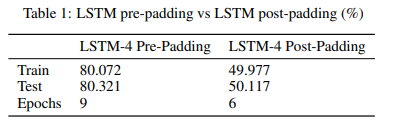

[Reference] EFFECTS OF PADDING ON LSTMS AND CNNS, Dwarampudi Mahidhar Reddy, N V Subba Reddy

### **Target, Features, Validation split**


In [312]:
# Now that we have an array, let us slice the last word as the output.
# The preceding words are the input.
def get_features_and_label(data):
    X = data[:, :-1]
    y = data[:, -1]
    return X, y

X, y = get_features_and_label(pre_sequence_data)
print(f"Features: \n{X}\n\n")
print(f"Labels: \n{y}")

Features: 
[[  0   0   0 ...   0   0  22]
 [  0   0   0 ...   0  22   2]
 [  0   0   0 ...  22   2  54]
 ...
 [  0   0   0 ... 145   3   2]
 [  0   0   0 ...   3   2 611]
 [  0   0   0 ...   2 611   3]]


Labels: 
[  2  54   3 ... 611   3  17]


In [313]:
# Let us convert y to be a one-hot array.
labels_cat = to_categorical(y, num_classes=VOCABULARY_LEN)
y = labels_cat

In [314]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(f'Size of X_train: {len(X_train)}')
print(f'Size of X_val: {len(X_val)}')

Size of X_train: 7036
Size of X_val: 1759


## **Data Augmentation**

This process involves using NLTK's part-of-speech tagging to figure out the role of each word. Then, it transforms these tags into a format that works well with WordNet. Finally, it selects synonyms considering the word's specific part of speech, ensuring that the sentence remains grammatically correct.

#### Replacement functions


In [520]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download('omw-1.4')

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

def synonym_replacement(text, n=1):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    augmented_texts = []

    for _ in range(n):
        new_words = words.copy()

        for i, word in enumerate(words):
            if random.random() < 0.2:  # Probability of replacing a word
                wordnet_pos = get_wordnet_pos(pos_tags[i][1])  # Get WordNet POS tag
                if wordnet_pos:
                    synonyms = get_synonyms(word, wordnet_pos)
                    if synonyms:
                        synonym = random.choice(synonyms)
                        new_words[i] = synonym

        augmented_texts.append(" ".join(new_words))

    return augmented_texts

def get_synonyms(word, pos):
    """Get synonyms of a word with the same part of speech."""
    synonyms = set()

    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            synonyms.add(
                lemma.name().replace("_", " ")
            )  # Replace underscores for multi-word synonyms

    if word in synonyms:
        synonyms.remove(word)

    return list(synonyms)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zzhen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zzhen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zzhen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zzhen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [521]:
data_augmented = []
for quote in data:
    original_text = quote
    augmented_texts = synonym_replacement(
        original_text, n=3
    )  # Generates 3 sentences with different synonyms

    data_augmented.extend(augmented_texts)  # Keep to one dimension

data_augmented_df = pd.DataFrame(data_augmented, columns=['Quotes'])
data_augmented_df.to_csv('./text_augmented.csv', index=False)
data_augmented[:5]

["Embrace the beauty of every sunrise ; it 's a fresh chance to paint your world with joy .",
 "Embrace the beauty of every sunrise ; it 's a fresh chance to paint your globe with joy .",
 "Embrace the beauty of every break of day ; it 's a refreshing chance to paint your world with joy .",
 'Embrace challenge ; they are the stepping stones to your greatest victories .',
 'Embrace challenges ; they are the stepping stones to your greatest victories .']

Notice that data augmentation was done before splitting data into train and validation sets. This is because the use of data augmentation is to generate more training data, not to ensure the model can accurately predict "right answers".

### Data preparation on Augmented Data


In [573]:
def data_preparation_pipeline(data):
    # Tokenization
    tokenizer = Tokenizer(filters='')  # Instantiate a Tokenizer object.
    clean_data = add_space_before_punctuation(data)
    tokenizer.fit_on_texts(clean_data)
    vocab_len = len(tokenizer.word_index) + 1

    # Converts each of the quotes from texts to integers.
    tokenized_sequences = []

    for datapoint in data:
        token_list = tokenizer.texts_to_sequences([datapoint])[0]
        tokenized_sequences.append(token_list)

    print(
        f"Total number of quotes converted from texts to integers: {len(tokenized_sequences)}"
    )

    # Splitting quotes
    def split_sentence(sentence):
        words = sentence
        incremental_splits = [words[: i + 2] for i in range(len(words) - 1)]
        return incremental_splits

    sequence_data = []
    for sequence in tokenized_sequences:
        incremental_splits = split_sentence(sequence)
        sequence_data.extend(incremental_splits)

    # Padding
    max_sequence_len = max(
        [len(x) for x in sequence_data]
    )  # This is to get the longest sequence of texts.
    pre_sequence_data = np.array(
        pad_sequences(sequence_data, maxlen=max_sequence_len, padding="pre")
    )  # Keeps all sequences the same length

    # Train, Test, and Validation split
    def get_features_and_label(data):
        X = data[:, :-1]
        y = data[:, -1]
        return X, y

    features, labels = get_features_and_label(pre_sequence_data)
    labels = to_categorical(labels, num_classes=vocab_len)

    return (vocab_len, max_sequence_len, features, labels, tokenizer)

In [574]:

VOCAB_LEN_AUG, MAX_SEQ_LEN_AUG, X_aug, y_aug, augmented_tokenizer = data_preparation_pipeline(data_augmented)
X_aug_train, X_aug_val, y_aug_train, y_aug_val = train_test_split(X_aug, y_aug, test_size=0.2)


print(f'Size of X_aug_train: {len(X_aug_train)}')
print(f'Size of X_aug_val: {len(X_aug_val)}')
print(f'Number of unique tokens: {VOCAB_LEN_AUG}')
print(f'Maximum sequence length after augmentation: {MAX_SEQ_LEN_AUG}')

Total number of quotes converted from texts to integers: 3000
Size of X_aug_train: 31537
Size of X_aug_val: 7885
Number of unique tokens: 2419
Maximum sequence length after augmentation: 42


In [ ]:
augmented_tokenizer.texts_to_sequences()

## **Split by Character**

Predicting each upcoming word is a task that requires an extremely large number of examples (>100k). Given our smaller dataset, character prediction may be an easier task, as there are at most 26 outputs excluding punctuation.

**However it greatly limits the length of sentences that can be generated**

Character-level text generation has several challenges, including the lack of context, longer training times, increased resource requirements, spelling errors, difficulty with punctuation and formatting, limited semantic understanding, data requirements, and limited control. To overcome these issues, hybrid models and post-processing techniques can be employed.

In [318]:
# Data Cleaning and Preprocessing
data_lower = [s.lower() for s in data]  # Convert to lowercase (To keep only lower case classes)

# Instantiate the vectors
sentences = []
next_chars = []

chars_window = 50 # Determined by the length distribution of data
step = 1
for sentence in data_lower:
    # Get 50 previous chars and next char; then shift by step
    for i in range(0, len(sentence) - chars_window, step):
        sentences.append(sentence[i:i + chars_window])
        next_chars.append(sentence[i + chars_window])

# Define a Data Frame with the vectors
df = pd.DataFrame({'sentence': sentences, 'next_char': next_chars})

# Print the initial rows
print(df.head())

                                            sentence next_char
0  embrace the beauty of every sunrise; it's a fr...         c
1  mbrace the beauty of every sunrise; it's a fre...         h
2  brace the beauty of every sunrise; it's a fres...         a
3  race the beauty of every sunrise; it's a fresh...         n
4  ace the beauty of every sunrise; it's a fresh ...         c


#### Tokenize every character

In [319]:
char_tokenizer = Tokenizer(
    lower=True,
    filters='',
    char_level=True
)
char_tokenizer.fit_on_texts(data_lower)

CHAR_N_VOCAB = len(char_tokenizer.word_index) + 1
CHAR_WORD_INDEX = char_tokenizer.word_index

##### Encoding every sentence by character

In [320]:
num_seqs = len(sentences)
n_vocab = CHAR_N_VOCAB
char_to_index = CHAR_WORD_INDEX

X_char = np.zeros((num_seqs, chars_window))
y_char = np.zeros((num_seqs, n_vocab))

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X_char[i, t] = char_to_index[char]
    y_char[i, char_to_index[next_chars[i]]] = 1

# Print the first position of each
print(X_char[0], y_char[0], sep="\n")

[ 2. 19. 21.  5.  7. 16.  2.  1.  3. 10.  2.  1. 21.  2.  7. 12.  3. 14.
  1.  4. 13.  1.  2. 23.  2.  5. 14.  1.  8. 12.  9.  5.  6.  8.  2. 28.
  1.  6.  3. 25.  8.  1.  7.  1. 13.  5.  2.  8. 10.  1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##### Train, Val split

In [321]:
X_char_train, X_char_val, y_char_train, y_char_val = train_test_split(X_char, y_char, test_size=0.2)
print(f'Size of X_char_train: {len(X_char_train)}')
print(f'Size of X_char_val: {len(X_char_val)}')

Size of X_char_train: 15205
Size of X_char_val: 3802


# **MODELLING**


### **EVALUATION METRICS**


#### Text Output Analysis

1. **Relevance**:
   - Is the content on-topic and related to the subject matter?

2. **Coherence and Flow**:
   - Does the text have a logical flow of ideas and sentences?
   - Are there any abrupt transitions or disjointed sentences?

3. **Grammar and Spelling**:
   - Are there any grammatical errors or misspelled words in the generated text?
   - Does the text use proper punctuation and capitalization?

4. **Consistency**:
   - Is the style and tone of the generated text consistent throughout?
   - Are there any sudden shifts in perspective or language?

5. **Originality**:
   - Does the generated text contain any plagiarized content or closely resemble existing material?
   - Is the content sufficiently original and not copied from the training data or external sources?

6. **Clarity**:
   - Is the text clear and easily understandable?
   - Are there any ambiguities or confusing passages?


Required input texts

In [456]:
seed_texts = [
    "embrace each day",
    "radiate some",
    "believe that",
    "life's actual purpose is",
    "dance through each and every",
    "let your time and energy",
    "every person is",
    "our country Singapore is",
    "planet earth is",
    "morning and evening would make it",
]

# Human generated complete texts
seed_texts_references = [
    " with a heart full of gratitude and enthusiasm, and make the most of every opportunity that comes your way.",
    " positive vibes to brighten the lives of those around you, spreading happiness and joy wherever you go.",
    " the universe conspires to help you achieve your dreams, and with determination, you can overcome any obstacle.",
    " to explore the beauty of existence, connect with others, and leave a lasting, positive impact on the world.",
    " moment of your life as if it were a celebration, savoring the rhythm of the journey.",
    " be invested in things that align with your passions and values, for they are the true treasures of life.",
    " a complex tapestry of experiences, emotions, and dreams, deserving of empathy, understanding, and respect.",
    " a vibrant melting pot of cultures, innovation, and progress, making it a remarkable place to call home.",
    " a precious oasis in the vast cosmos, and it's our responsibility to protect and preserve its natural wonders.",
    " easier to establish a consistent routine, allowing you to accomplish your daily goals and find balance in life."
]

Probability scaling

**Temperature**
> a hyperparameter that can be used to control the randomness and creativity of the generated text in a generative language model. Higher temperature = more random and creative. Low temperature = less random and standardized.

In [323]:
np.seterr(divide = 'ignore') 
def scale_softmax(softmax_pred, temperature=1.0):
    # Convert predictions to a numpy array and adjust for temperature
    softmax_pred = np.asarray(softmax_pred).astype('float64')
    softmax_pred = np.log(softmax_pred) / temperature
    exp_softmax_pred = np.exp(softmax_pred)
    softmax_pred = exp_softmax_pred / np.sum(exp_softmax_pred)

    # Sample a prediction from the probability distribution
    probas = np.random.multinomial(1, softmax_pred, 1)
    return np.argmax(probas)

#### **Next word prediction**

In [324]:
def predict_next_words(input_text, model, max_sequence_len, no_of_words=10, temperature=1.0):
    tokens = tokenizer.texts_to_sequences([input_text])[0] # Convert your input text into integers.

    predicted_words = []
    for _ in range(no_of_words):
        tokens_padded = pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre') # Pad your sequence.
        predictions = model.predict(tokens_padded, verbose=0) # Get the prediction as softmax probabilities.
        
        # Apply temperature scaling and get the new prediction
        scaled_prediction = scale_softmax(predictions[0], temperature)
        predicted_word = tokenizer.sequences_to_texts([[scaled_prediction]])[0] # Convert scaled prediction to word.
        predicted_words.append(predicted_word)

        # Update tokens with the new prediction for the next iteration.
        tokens = tokens + [scaled_prediction]
        if len(tokens) > max_sequence_len-1:
            tokens = tokens[1:] # Ensure tokens length is within the max_sequence_len.

    return ' '.join(predicted_words)

#### **Next character prediction**

In [325]:
def predict_next_char(model, input_text, temperature=1.0, no_of_chars=10):
    # Convert seed_text sentences into chars for input
    def sentence_to_chars(input_sentence):
        data_char = ""
        for char in input_sentence.lower():
            data_char += char
        return data_char

    sentence = sentence_to_chars(input_text)
    generated = ""
    generated += sentence

    for _ in range(no_of_chars):  # number of characters to generate
        x_pred = np.zeros((1, chars_window))
        for t, char in enumerate(sentence):
            x_pred[0, t] = char_tokenizer.word_index.get(
                char, 0
            )  # Map char to index with default for unknown chars

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = scale_softmax(preds, temperature=temperature)

        # Convert index back to char
        next_char = char_tokenizer.sequences_to_texts([[next_index]])[0]
        generated += next_char

        # Update sentence with new character, ensuring its length stays consistent
        sentence = sentence[1:] + next_char

    return generated

#### **Training plots**

For evaluating text generation models, we cant use metrics such as accuracy because we want our model to generate a range of answers and not get fixated on getting an exact answer each time. We need to generate sentences and be evaluated by humans, or on the linguistic level.

In [446]:
def plot_history(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "b-o", label="Training Loss")
    plt.plot(epochs, val_loss, "g-x", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Dynamic x-axis ticks for loss plot
    tick_spacing = max(1, len(epochs) // 10)
    plt.xticks(epochs[::tick_spacing])

    min_val_loss = min(loss)
    plt.text(
        len(epochs) * 0.8,
        min_val_loss * 1.01,
        f"Min Loss: {min_val_loss:.4f}",
        fontsize=9,
    )

    plt.tight_layout()
    plt.show()

all_results = pd.DataFrame()
def store_result(modelInfo, linguistic_score, description):
    history = modelInfo.history
    best_val_idx = np.argmin(history["val_loss"])
    result = {}
    result["Model Name"] = modelInfo.model._name
    result["Description"] = description
    result["Linguistic_score"] = linguistic_score
    result["Train Loss"] = history["loss"][best_val_idx]
    result["Val Loss"] = history["val_loss"][best_val_idx]
    result["Epochs"] = len(history["loss"])
    result = pd.DataFrame([result])
    global all_results
    all_results = pd.concat([all_results, result], ignore_index=True)
    return result

def reset_model(model):
    if model:
        del model
    K.clear_session()
    tf.compat.v1.reset_default_graph()

### **Callbacks**


**EarlyStopping:**

- Monitors a metric during training and stops the training process if the metric stops improving. Helps prevent overfitting.

**ModelCheckpoint:**

- Saves the model's weights at specified intervals during training for later loading and evaluation.

**ReduceLROnPlateau:**

- Reduces the learning rate when a metric has stopped improving. Often used in conjunction with EarlyStopping.


In [327]:
def model_checkpoint(file):
    return ModelCheckpoint(
        filepath=f"./best weights/{file}",
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    )

early_stop = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=0.0000001
)

## **BASE MODEL**


In [480]:
def base_rnn(vocab_len, input_length=None, name="base_RNN"):
    base_model = Sequential(name=name)
    base_model.add(Embedding(input_dim=vocab_len, output_dim=64, input_length=input_length))
    base_model.add(SimpleRNN(units=64, activation="relu"))
    base_model.add(Dense(vocab_len, activation="softmax"))
    base_model.compile(optimizer="adam", loss="categorical_crossentropy")
    return base_model

base_rnn_model = base_rnn(VOCABULARY_LEN)
base_rnn_model.summary()

Model: "base_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          76480     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1195)              77675     
                                                                 
Total params: 162411 (634.42 KB)
Trainable params: 162411 (634.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/40
220/220 [==============================] - 4s 12ms/step - loss: 5.2610 - val_loss: 4.8497 - lr: 0.0010
Epoch 2/40
220/220 [==============================] - 3s 12ms/step - loss: 4.3051 - val_loss: 4.1154 - lr: 0.0010
Epoch 3/40
220/220 [==============================] - 4s 17ms/step - loss: 3.5901 - val_loss: 3.6497 - lr: 0.0010
Epoch 4/40
220/220 [==============================] - 3s 16ms/step - loss: 3.0435 - val_loss: 3.3988 - lr: 0.0010
Epoch 5/40
220/220 [==============================] - 3s 14ms/step - loss: 2.6631 - val_loss: 3.3466 - lr: 0.0010
Epoch 6/40
220/220 [==============================] - 3s 13ms/step - loss: 2.3637 - val_loss: 3.2293 - lr: 0.0010
Epoch 7/40
220/220 [==============================] - 3s 13ms/step - loss: 2.1032 - val_loss: 3.2868 - lr: 0.0010
Epoch 8/40
220/220 [==============================] - 3s 13ms/step - loss: 1.8804 - val_loss: 3.2798 - lr: 0.0010
Epoch 9/40
220/220 [==============================] - 3s 13ms/step - loss: 1.6750 - val_

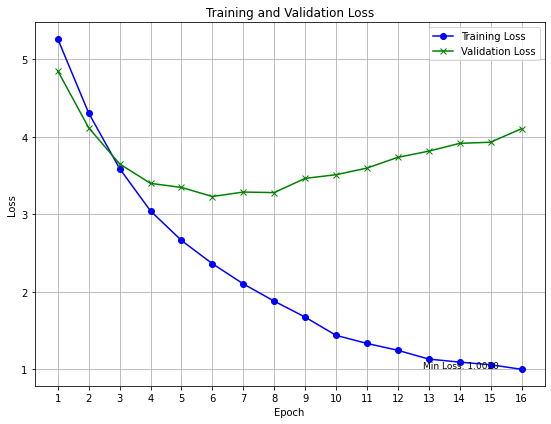

In [329]:
reset_model(base_rnn_model)

base_rnn_model = base_rnn(VOCABULARY_LEN)

base_model_history = base_rnn_model.fit(
    X_train,
    y_train,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
)
plot_history(base_model_history)

In [457]:
generated_sentences = []
for text in seed_texts:
    generated_sentence = predict_next_words(
        text, base_rnn_model, MAX_SEQ_LEN, temperature=2, no_of_words=10
    )
    generated_sentences.append(generated_sentence)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentence}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: by kindness be the chaos are make this cities bring
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: dreams by it holds lullaby free and across opportunities share
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: act of can enough trail your action lies any blessings
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: find is every inspire ebb flow brighter be a than
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: taken source our go they towards nurtured and marine wisdom
----------------

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 1/10    |
| Coherence and Flow  | 0/10    |
| Grammar and Spelling| 0/10    |
| Consistency          | 9/10    |
| Originality          | 10/10   |
| Clarity              | 0/10    |
| **Total**              | **20/60**    |

In [467]:
store_result(base_model_history, 25, 'Base RNN model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,base_RNN,Base RNN model,25,2.363711,3.22929,16


## **BASE MODEL** (augmented)


Epoch 1/60
1232/1232 [==============================] - 17s 12ms/step - loss: 4.6113 - val_loss: 3.4271 - lr: 0.0010
Epoch 2/60
1232/1232 [==============================] - 20s 16ms/step - loss: 3.1171 - val_loss: 2.6889 - lr: 0.0010
Epoch 3/60
1232/1232 [==============================] - 20s 17ms/step - loss: 2.5249 - val_loss: 2.2031 - lr: 0.0010
Epoch 4/60
1232/1232 [==============================] - 20s 16ms/step - loss: 2.0945 - val_loss: 1.8141 - lr: 0.0010
Epoch 5/60
1232/1232 [==============================] - 20s 16ms/step - loss: 1.7615 - val_loss: 1.4968 - lr: 0.0010
Epoch 6/60
1232/1232 [==============================] - 20s 16ms/step - loss: 1.5046 - val_loss: 1.2982 - lr: 0.0010
Epoch 7/60
1232/1232 [==============================] - 20s 16ms/step - loss: 1.3159 - val_loss: 1.1419 - lr: 0.0010
Epoch 8/60
1232/1232 [==============================] - 20s 17ms/step - loss: 1.1760 - val_loss: 1.0090 - lr: 0.0010
Epoch 9/60
1232/1232 [==============================] - 22s 18ms

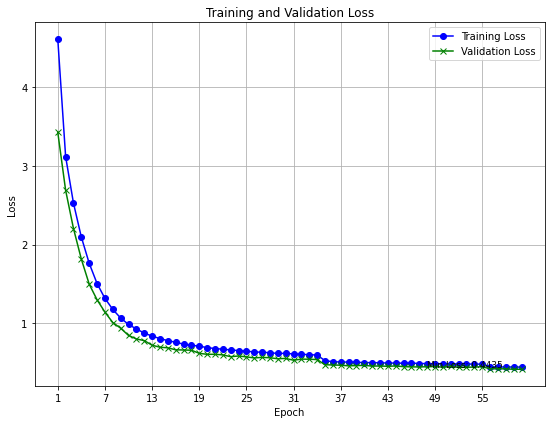

In [519]:
reset_model(base_rnn_model)

base_rnn_model_aug = base_rnn(VOCAB_LEN_AUG)

base_model_aug_history = base_rnn_model_aug.fit(
    X_aug,
    y_aug,
    epochs=60,
    validation_data=(X_aug_val, y_aug_val),
    callbacks=[early_stop, reduce_lr],
)

# store_result(base_model_aug_history, description="augmented")
plot_history(base_model_aug_history)

In [468]:
for text in seed_texts:
    generated_sentences = predict_next_words(text, base_rnn_model_aug, MAX_SEQ_LEN)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: faith your planet to the ripples . your tapestry .
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: determination , is let for the reflect  in every
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: 's curiosity be landscapes 's humanity of love and big
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: let when the lullaby . our morning 's pulse .
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: 's solitude you be your speak  . . .
-------------------------------------------------- 

-----

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 0/10    |
| Coherence and Flow  | 0/10    |
| Grammar and Spelling| 0/10    |
| Consistency          | 9/10    |
| Originality          | 10/10   |
| Clarity              | 0/10    |
| **Total**              | **19/60**    |

In [481]:
store_result(base_model_aug_history, 19, 'Base Augmented RNN model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,base_RNN,Base Augmented RNN model,19,0.474447,0.432215,60


With augmentation, loss managed to decrease by 0.02, which may not be that significant. But the texts generated with out augmented model produced way more punctuation, which is what I wanted the quotes to have. Thus augmentation produced better results, despite its sentences being less legible.

## **BASE MODEL** (character prediction)

Epoch 1/50
149/149 [==============================] - 5s 24ms/step - loss: 2.9742 - val_loss: 2.6124
Epoch 2/50
149/149 [==============================] - 3s 22ms/step - loss: 2.4136 - val_loss: 2.2428
Epoch 3/50
149/149 [==============================] - 3s 23ms/step - loss: 2.1648 - val_loss: 2.0594
Epoch 4/50
149/149 [==============================] - 3s 22ms/step - loss: 2.0086 - val_loss: 1.9199
Epoch 5/50
149/149 [==============================] - 3s 21ms/step - loss: 1.8952 - val_loss: 1.8370
Epoch 6/50
149/149 [==============================] - 3s 23ms/step - loss: 1.7996 - val_loss: 1.7309
Epoch 7/50
149/149 [==============================] - 3s 23ms/step - loss: 1.7239 - val_loss: 1.6740
Epoch 8/50
149/149 [==============================] - 3s 19ms/step - loss: 1.6633 - val_loss: 1.6135
Epoch 9/50
149/149 [==============================] - 3s 22ms/step - loss: 1.6108 - val_loss: 1.5862
Epoch 10/50
149/149 [==============================] - 3s 22ms/step - loss: 1.5681 - val_lo

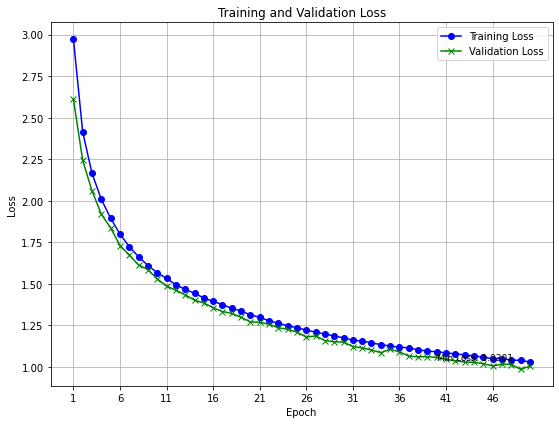

In [333]:
reset_model(base_rnn_model)

base_rnn_char_model = base_rnn(CHAR_N_VOCAB, chars_window)
base_model_char_history = base_rnn_char_model.fit(X_char, 
                                                y_char, 
                                                validation_data=(X_char_val, y_char_val),
                                                batch_size=128, 
                                                epochs=50)

plot_history(base_model_char_history)

### Text generation

In [579]:
for text in seed_texts:
    generated_sentences = predict_next_char(
        base_rnn_char_model, text, 
        temperature=2.0, no_of_chars=20
    )
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: embrace each day.,qfjasgtdzde.zasjme
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: radiate someaniblzs"icmlirdfc'bv
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: believe that,rftovy.rpwkr-.iqt'k
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: life's actual purpose is"iya't bzf" a eaylxd
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: dance through each and everystwtgtofzcsis-rmmsrs
-------------------------------------------------- 

----------------------------------------------

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 0/10    |
| Coherence and Flow  | 0/10    |
| Grammar and Spelling| 0/10    |
| Consistency          | 5/10    |
| Originality          | 10/10   |
| Clarity              | 0/10    |
| **Total**              | **15/60**    |

In [482]:
store_result(base_model_char_history, 15, 'Base Character RNN model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,base_RNN,Base Character RNN model,15,1.039982,0.986383,50


The model predicts characters that form words that are illegible. This may be because we are using a RNN with no gates. Predicting by words removes the risk of incorrect spelling; unless training data contains mispelled words.

### **Comparison of GRU and LSTM**

**Architecture**:
- *LSTM*: Three gate layers (input, forget, output gates).
- *GRU*: Two gate layers (update and reset gates).

**Computational Complexity**:
- *LSTM*: More computationally intensive due to extra gate layers.
- *GRU*: Less computationally intensive, faster to train.

**Parameter Size**:
- *LSTM*: Typically has more parameters.
- *GRU*: Fewer parameters, advantageous with limited data.

**Capturing Long-Term Dependencies**:
- *LSTM*: Effective at capturing long-term dependencies.
- *GRU*: Can capture dependencies, slightly less effective with very long sequences.

**Training Speed**:
- *GRU*: Converges faster during training due to simpler architecture.

**Use Cases**:
- *LSTM*: Preferred for tasks with complex, long-range dependencies (e.g., NLP, speech recognition).
- *GRU*: Suitable for tasks prioritizing computational efficiency or shorter-term dependencies.

Because of time and resoure constraint, I need a model that is less computationally intensive, with fewer parameters and converges faster. Also during EDA earlier, we concluded that quotes are not that long. Therefore we do not need a model that can capture very long-term dependencies.

So I will be using GRU (I will still do a quick comparison with LSTM)

## **LSTM MODEL**


In [335]:
def instantiate_lstm(vocab_len, input_length=None, name="lstm"):
    # Build model
    model = Sequential(name=name)
    model.add(Embedding(input_dim=vocab_len, output_dim=128, input_length=input_length))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dense(vocab_len, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model


lstm_model = instantiate_lstm(VOCABULARY_LEN)
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         152960    
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1195)              154155    
                                                                 
Total params: 570283 (2.18 MB)
Trainable params: 570283 (2.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
69/69 [==============================] - 31s 257ms/step - loss: 5.4100 - val_loss: 4.8581 - lr: 0.0010
Epoch 2/50
69/69 [==============================] - 16s 229ms/step - loss: 4.9281 - val_loss: 4.8274 - lr: 0.0010
Epoch 3/50
69/69 [==============================] - 17s 240ms/step - loss: 4.9136 - val_loss: 4.8314 - lr: 0.0010
Epoch 4/50
69/69 [==============================] - 17s 241ms/step - loss: 4.8870 - val_loss: 4.7452 - lr: 0.0010
Epoch 5/50
69/69 [==============================] - 16s 238ms/step - loss: 4.6378 - val_loss: 4.4557 - lr: 0.0010
Epoch 6/50
69/69 [==============================] - 16s 236ms/step - loss: 4.3858 - val_loss: 4.2472 - lr: 0.0010
Epoch 7/50
69/69 [==============================] - 17s 247ms/step - loss: 4.1989 - val_loss: 4.0745 - lr: 0.0010
Epoch 8/50
69/69 [==============================] - 17s 240ms/step - loss: 4.0458 - val_loss: 3.9357 - lr: 0.0010
Epoch 9/50
69/69 [==============================] - 18s 254ms/step - loss: 3.9170 - val_

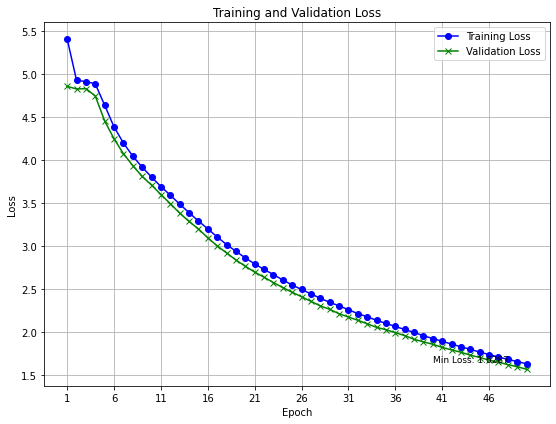

In [336]:
reset_model(lstm_model)

lstm_model = instantiate_lstm(VOCABULARY_LEN)

lstm_model_history = lstm_model.fit(
    X,
    y,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128, 
    callbacks=[early_stop, reduce_lr],
)
plot_history(lstm_model_history)

In [580]:
for text in seed_texts:
    generated_sentences = predict_next_words(text, lstm_model, MAX_SEQ_LEN)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: is a energy to the journey of progress and every
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: for you are be every corner you leave should many
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: light for a planet welcome the strength to new and
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: rich for you are through for it is a bountiful
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: hold the reminders of your and compassion knows the fills
-----------------------------------------

## **GRU MODEL**


In [338]:
def instantiate_gru(vocab_len, input_length=None, name="gru"):
    # Build model
    model = Sequential(name=name)
    model.add(Embedding(input_dim=vocab_len, output_dim=128, input_length=input_length))
    model.add(GRU(units=128, return_sequences=True))
    model.add(GRU(units=128, return_sequences=False))
    model.add(Dense(vocab_len, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

gru_model = instantiate_gru(VOCABULARY_LEN)
gru_model.summary()

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         152960    
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 1195)              154155    
                                                                 
Total params: 505259 (1.93 MB)
Trainable params: 505259 (1.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
275/275 [==============================] - 27s 77ms/step - loss: 5.1898 - val_loss: 4.8545 - lr: 0.0010
Epoch 2/50
275/275 [==============================] - 20s 73ms/step - loss: 4.6156 - val_loss: 4.2570 - lr: 0.0010
Epoch 3/50
275/275 [==============================] - 21s 75ms/step - loss: 4.0711 - val_loss: 3.6172 - lr: 0.0010
Epoch 4/50
275/275 [==============================] - 21s 75ms/step - loss: 3.4372 - val_loss: 3.0544 - lr: 0.0010
Epoch 5/50
275/275 [==============================] - 20s 73ms/step - loss: 2.9610 - val_loss: 2.6230 - lr: 0.0010
Epoch 6/50
275/275 [==============================] - 20s 74ms/step - loss: 2.5865 - val_loss: 2.2843 - lr: 0.0010
Epoch 7/50
275/275 [==============================] - 20s 74ms/step - loss: 2.2727 - val_loss: 2.0089 - lr: 0.0010
Epoch 8/50
275/275 [==============================] - 20s 74ms/step - loss: 2.0169 - val_loss: 1.7646 - lr: 0.0010
Epoch 9/50
275/275 [==============================] - 21s 75ms/step - loss: 1.79

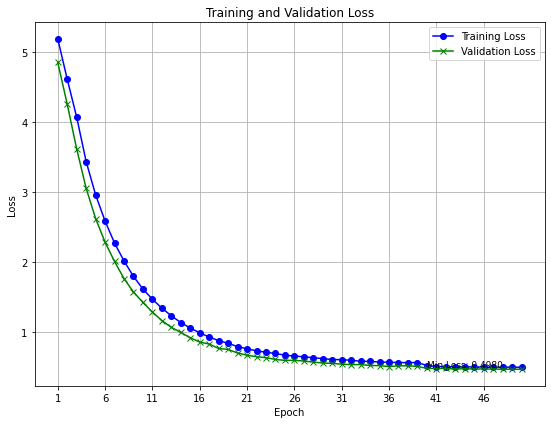

In [339]:
reset_model(gru_model)

gru_model = instantiate_gru(VOCABULARY_LEN)

gru_model_history = gru_model.fit(
    X,
    y,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)
plot_history(gru_model_history)

In [581]:
for text in seed_texts:
    generated_sentences = predict_next_words(text, gru_model, MAX_SEQ_LEN)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: brings your for you be the only constant in refreshment
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: and let it light up the lives of those around
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: sunrise be a beacon of light for the old for
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: a testament to the beauty of our witness the fiery
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: power to lift you are the wide heartbeats in arid
------------------------------------------------

### Comparing LSTM to GRU, there are a few differences
Model training for GRU went more smoothly than LSTM; Between epochs 24 to 31, there was a spike in loss for LSTM

|   **GRU**   |                       |   **LSTM**   |                       |
|----------------------|---------|----------------------|---------|
| Criteria              | Score   | Criteria              | Score   |
|----------------------|---------|----------------------|---------|
| Relevance             | 5/10    | Relevance             | 3/10    |
| Coherence and Flow   | 8/10    | Coherence and Flow   | 3/10    |
| Grammar and Spelling | 5/10    | Grammar and Spelling | 5/10    |
| Consistency           | 10/10   | Consistency           | 10/10   |
| Originality           | 9/10    | Originality           | 9/10    |
| Clarity               | 1/10    | Clarity               | 1/10    |
| **Total**             | **38/60**| **Total**             | **31/60**|


Overall, GRU performed better in our technical analysis and language analysis. Thus **we will be focusing on GRU**.

In [483]:
store_result(lstm_model_history, 31, 'LSTM model')
store_result(gru_model_history, 38, 'GRU model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,gru,GRU model,38,0.497999,0.468535,50


## **GRU MODEL** (augmented)

Epoch 1/40
308/308 [==============================] - 96s 294ms/step - loss: 5.5541 - val_loss: 5.3072 - lr: 0.0010
Epoch 2/40
308/308 [==============================] - 87s 283ms/step - loss: 5.3460 - val_loss: 5.0951 - lr: 0.0010
Epoch 3/40
308/308 [==============================] - 84s 272ms/step - loss: 4.9619 - val_loss: 4.5789 - lr: 0.0010
Epoch 4/40
308/308 [==============================] - 80s 260ms/step - loss: 4.0524 - val_loss: 3.4212 - lr: 0.0010
Epoch 5/40
308/308 [==============================] - 82s 268ms/step - loss: 3.1848 - val_loss: 2.7635 - lr: 0.0010
Epoch 6/40
308/308 [==============================] - 88s 284ms/step - loss: 2.6606 - val_loss: 2.3352 - lr: 0.0010
Epoch 7/40
308/308 [==============================] - 84s 272ms/step - loss: 2.2829 - val_loss: 2.0137 - lr: 0.0010
Epoch 8/40
308/308 [==============================] - 82s 265ms/step - loss: 1.9942 - val_loss: 1.7671 - lr: 0.0010
Epoch 9/40
308/308 [==============================] - 81s 263ms/step - l

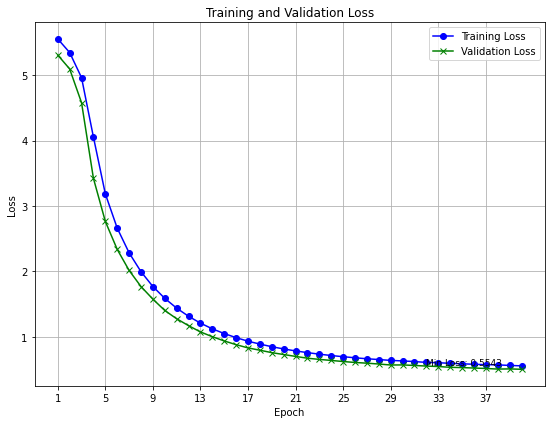

In [342]:
reset_model(gru_model)

gru_model_aug = instantiate_gru(VOCAB_LEN_AUG)

gru_model_aug_history = gru_model_aug.fit(
    X_aug,
    y_aug,
    validation_data=(X_aug_val, y_aug_val),
    epochs=40,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)
# store_result(gru_model_aug_history)
plot_history(gru_model_aug_history)

GRU got a higher loss with augmented data (0.55) than non-augmented data (0.49)

In [582]:
for text in seed_texts:
    generated_sentences = predict_next_words(text, gru_model_aug, MAX_SEQ_LEN)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: limits , yourself 's  singapore the rich  wings
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: the chambers of the southeast symphony they paint the harmony
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: blessings your blooms rain is the light be brilliance .
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: your hope 's strength to the peace you nurtured bridge
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: , life knows story hear tranquility be  . .
-------------------------------

As expected, our augmented dataset allowed our GRU model to produce punctuations. However, the sentences generated are alot worse than the sentences generated without augmentation.

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 1/10    |
| Coherence and Flow  | 2/10    |
| Grammar and Spelling| 2/10    |
| Consistency          | 10/10    |
| Originality          | 9/10   |
| Clarity              | 0/10    |
| **Total**              | **24/60**    |

This is likely due to the large number of new words introduced from augmentation. It also gave way to more punctuation examples, allowing our model to be more confident predicting punctuation, albeit badly.

There seems to be repetition in the punctuation, so let us explore if a sequence processing model that consists of two GRUs, one taking the input in a forward direction, and the other in a backwards direction, helps.

In [484]:
store_result(gru_model_aug_history, 24, 'GRU augmented model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,gru,GRU augmented model,24,0.554282,0.501867,40


## **GRU MODEL** (Bidirectional)

In [344]:
def bidirectional_gru_model(vocab_len, input_length=None, name="bi-gru"):
    model = Sequential([
        Embedding(input_dim=vocab_len, output_dim=128, input_length=input_length),
        Bidirectional(GRU(units=64, return_sequences=True)),
        Bidirectional(GRU(units=64)),
        Dense(units=vocab_len, activation='softmax')
    ], name=name)

    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

bidirectional_gru = bidirectional_gru_model(VOCAB_LEN_AUG, MAX_SEQ_LEN_AUG)
bidirectional_gru.summary()

Model: "bi-gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 43, 128)           305920    
                                                                 
 bidirectional (Bidirection  (None, 43, 128)           74496     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 2390)              308310    
                                                                 
Total params: 763222 (2.91 MB)
Trainable params: 763222 (2.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
308/308 [==============================] - 83s 243ms/step - loss: 5.3606 - val_loss: 4.7615 - lr: 0.0010
Epoch 2/50
308/308 [==============================] - 74s 241ms/step - loss: 4.4835 - val_loss: 4.0206 - lr: 0.0010
Epoch 3/50
308/308 [==============================] - 74s 240ms/step - loss: 3.8084 - val_loss: 3.4406 - lr: 0.0010
Epoch 4/50
308/308 [==============================] - 74s 240ms/step - loss: 3.3355 - val_loss: 3.0546 - lr: 0.0010
Epoch 5/50
308/308 [==============================] - 75s 242ms/step - loss: 2.9936 - val_loss: 2.7611 - lr: 0.0010
Epoch 6/50
308/308 [==============================] - 74s 240ms/step - loss: 2.7270 - val_loss: 2.5151 - lr: 0.0010
Epoch 7/50
308/308 [==============================] - 73s 239ms/step - loss: 2.5060 - val_loss: 2.3335 - lr: 0.0010
Epoch 8/50
308/308 [==============================] - 74s 240ms/step - loss: 2.3278 - val_loss: 2.1659 - lr: 0.0010
Epoch 9/50
308/308 [==============================] - 74s 242ms/step - l

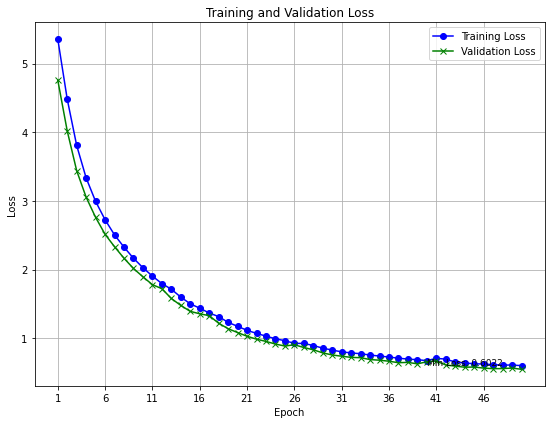

In [345]:
bidirectional_gru = bidirectional_gru_model(VOCAB_LEN_AUG)

bidirectional_gru_history = bidirectional_gru.fit(
    X_aug,
    y_aug,
    validation_data=(X_aug_val, y_aug_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)
# store_result(bidirectional_gru_history)
plot_history(bidirectional_gru_history)

In [584]:
for text in seed_texts:
    generated_sentences = predict_next_words(text, bidirectional_gru, MAX_SEQ_LEN)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: comes you reality the  of your understanding glorious carry
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: the power of flavors symphony they lighthouse the hope and
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: nurseries for a delicate of nature is the garden of
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: the positivity , universe behind of the attract , a
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: and wounds and watered inspire in ordinary warm . .
---------------------

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 1/10    |
| Coherence and Flow  | 0/10    |
| Grammar and Spelling| 3/10    |
| Consistency          | 10/10    |
| Originality          | 10/10   |
| Clarity              | 0/10    |
| **Total**              | **24/60**    |

In [485]:
store_result(bidirectional_gru_history, 24, 'Bi-GRU augmented model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,bi-gru,Bi-GRU augmented model,24,0.602184,0.549019,50


Using a Bidirectional GRU seems to reduce the number of repeated tokens, such as trailing full stops.

## **GRU MODEL** (character prediction)

Epoch 1/30
149/149 [==============================] - 41s 246ms/step - loss: 2.7640 - val_loss: 2.2572 - lr: 0.0010
Epoch 2/30
149/149 [==============================] - 36s 242ms/step - loss: 2.0701 - val_loss: 1.8748 - lr: 0.0010
Epoch 3/30
149/149 [==============================] - 36s 242ms/step - loss: 1.7789 - val_loss: 1.6192 - lr: 0.0010
Epoch 4/30
149/149 [==============================] - 36s 243ms/step - loss: 1.5564 - val_loss: 1.4246 - lr: 0.0010
Epoch 5/30
149/149 [==============================] - 36s 241ms/step - loss: 1.3905 - val_loss: 1.2686 - lr: 0.0010
Epoch 6/30
149/149 [==============================] - 37s 248ms/step - loss: 1.2566 - val_loss: 1.1410 - lr: 0.0010
Epoch 7/30
149/149 [==============================] - 36s 245ms/step - loss: 1.1463 - val_loss: 1.0299 - lr: 0.0010
Epoch 8/30
149/149 [==============================] - 36s 241ms/step - loss: 1.0481 - val_loss: 0.9496 - lr: 0.0010
Epoch 9/30
149/149 [==============================] - 36s 241ms/step - l

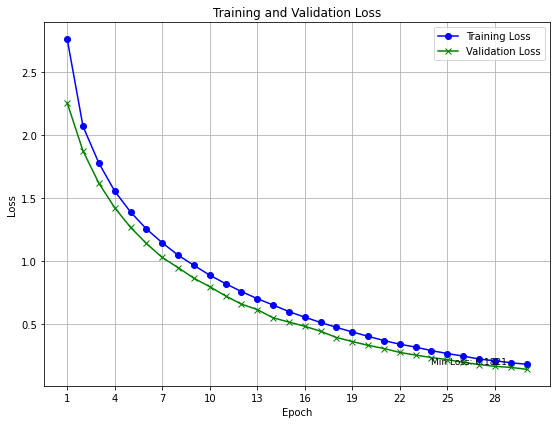

In [347]:
reset_model(gru_model)

gru_char_model = instantiate_gru(CHAR_N_VOCAB, chars_window)

gru_char_model_history = gru_char_model.fit(
    X_char,
    y_char,
    validation_data=(X_char_val, y_char_val),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)
# store_result(gru_char_model_history)
plot_history(gru_char_model_history)

In [585]:
for text in seed_texts:
    generated_sentences = predict_next_char(gru_char_model, text, temperature=1)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: embrace each dayaaaa  yeg.
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: radiate someeaieaaiyaa
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: believe thateaaaaaaeea
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: life's actual purpose isiesaaayaai
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: dance through each and everya ei,eeiya
-------------------------------------------------- 

--------------------------------------------------
Input text: let your time and energy
Generate

With character prediction, there are a lot of repeated predictions. These letters tend to be `a` and `e`. These two letters are the top 2 most used letters in the english language. Our model predicts them frequently because there are more examples of `a` and `e`, which makes it more "comfortable" to predict them. We can see difference by adjusting `temperature`

In [586]:
# Temperature = 2
for text in seed_texts:
    generated_sentences = predict_next_char(gru_char_model, text, temperature=3)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: embrace each day.n"ayssbkf
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: radiate some yiv.aep,s
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: believe that .eoo.za;o
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: life's actual purpose isiaetyg'y-o
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: dance through each and everyy,,za y.ci
-------------------------------------------------- 

--------------------------------------------------
Input text: let your time and energy
Generate

There is less repetition now

# **Transformers**

A Transformer is a deep learning model architecture designed for various natural language processing tasks, such as machine translation and text generation. It relies on a **self-attention mechanism** to capture relationships between different words or elements in a sequence, allowing it to process input data in parallel and at different positions, making it highly efficient for long sequences, and getting great performance.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="350" height="500">


#### Transformer utils
1. Attention mask
2. Transformer block
3. TokenAndPositionEmbedding
4. Sandardize text (handles punctuation, etc...)

In [474]:
@K.saving.register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(
        self,
        embed_dim,
        num_heads,
        ff_dim,
        rate=0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """
        Mask the upper half of the dot product matrix in self attention.
        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config["embed_dim"] = self.embed_dim
        config["num_heads"] = self.num_heads
        config["ff_dim"] = self.ff_dim
        config["rate"] = self.rate
        return config


@K.saving.register_keras_serializable()
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config["maxlen"] = self.maxlen
        config["vocab_size"] = self.vocab_size
        config["embed_dim"] = self.embed_dim
        return config


def custom_standardization(input_string):
    """Remove line-break tags and handle punctuation"""
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "\n", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")

#### Loading data

I am using augmented data as transformers requires a large number of data and it has shown to promote the prediction of punctuation.

In [610]:
batch_size = 128

text_ds = tf.data.TextLineDataset('./text_augmented.csv')
text_ds = text_ds.shuffle(buffer_size=128)
DATASET_SIZE = pd.read_csv('./text_augmented.csv').shape[0]

train_size = int(0.80 * DATASET_SIZE)
train_ds = text_ds.take(train_size)
train_ds = train_ds.batch(batch_size)

val_size = int(0.20 * DATASET_SIZE)
val_ds = text_ds.skip(train_size)
val_ds = text_ds.take(val_size)
val_ds = val_ds.batch(batch_size)

In [611]:
vocab_size = VOCAB_LEN_AUG  # Only consider the top 20k words
maxlen = MAX_SEQ_LEN_AUG  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer
epochs = 20

#### Vectorization

In [612]:
# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(train_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

#### Data Preparation

In [615]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

shift_train_ds = train_ds.map(prepare_lm_inputs_labels)
train_ds_autotuned = shift_train_ds.prefetch(tf.data.AUTOTUNE)

#### Build model

In [438]:
def create_model():
    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = Dense(vocab_size)(x)
    model = Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam",
        loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

### Training Transformer

In [616]:
# Prepare validation data
shift_train_ds = val_ds.map(prepare_lm_inputs_labels)
val_ds_autotuned = shift_train_ds.prefetch(tf.data.AUTOTUNE)

Epoch 1/20
19/19 [==============================] - 16s 660ms/step - loss: 3.0838 - dense_5_loss: 3.0838 - val_loss: 1.6013 - val_dense_5_loss: 1.6013
Epoch 2/20
19/19 [==============================] - 13s 669ms/step - loss: 1.5619 - dense_5_loss: 1.5619 - val_loss: 1.1916 - val_dense_5_loss: 1.1916
Epoch 3/20
19/19 [==============================] - 12s 611ms/step - loss: 1.2496 - dense_5_loss: 1.2496 - val_loss: 1.0805 - val_dense_5_loss: 1.0805
Epoch 4/20
19/19 [==============================] - 12s 623ms/step - loss: 1.0610 - dense_5_loss: 1.0610 - val_loss: 0.8548 - val_dense_5_loss: 0.8548
Epoch 5/20
19/19 [==============================] - 12s 643ms/step - loss: 0.9072 - dense_5_loss: 0.9072 - val_loss: 0.8069 - val_dense_5_loss: 0.8069
Epoch 6/20
19/19 [==============================] - 12s 653ms/step - loss: 0.8021 - dense_5_loss: 0.8021 - val_loss: 0.6895 - val_dense_5_loss: 0.6895
Epoch 7/20
19/19 [==============================] - 13s 689ms/step - loss: 0.7133 - dense_5_lo

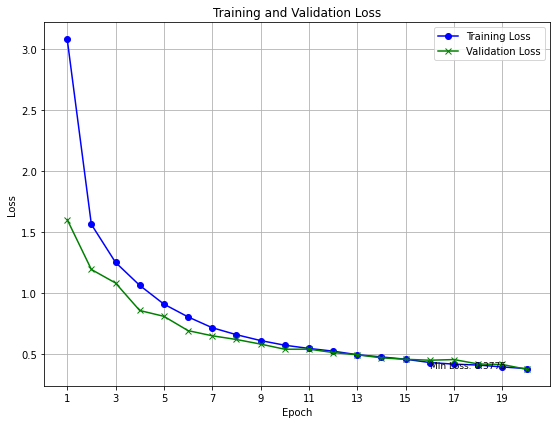

In [439]:
transformer_model = create_model()
transformer_model_history = transformer_model.fit(
    train_ds_autotuned, validation_data=val_ds_autotuned, epochs=20
)
plot_history(transformer_model_history)

### Text Generation

In [420]:
def transformer_text_generator(start_tokens, transformer_model, max_tokens=10):
    def sample_from(logits):
        logits, indices = tf.math.top_k(logits, k=10, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(number):
        return vocab[number]

    start_tokens = [_ for _ in start_tokens]
    num_tokens_generated = 0
    tokens_generated = []
    while num_tokens_generated < max_tokens:
        pad_len = maxlen - len(start_tokens)
        sample_index = len(start_tokens) - 1
        if pad_len < 0:
            x = start_tokens[:maxlen]
            sample_index = maxlen - 1
        elif pad_len > 0:
            x = start_tokens + [0] * pad_len
        else:
            x = start_tokens

        x = np.array([x])
        y, _ = transformer_model.predict(x, verbose=0)
        sample_token = sample_from(y[0][sample_index])
        tokens_generated.append(sample_token)
        if sample_token == 2:
            break
        start_tokens.append(sample_token)
        num_tokens_generated = len(tokens_generated)

    txt = " ".join(
        [detokenize(_) for _ in tokens_generated]
    )

    return txt

In [432]:
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

for text in seed_texts:
    start_tokens = [word_to_index.get(_, 1) for _ in text.split()]
    generated_sentences = transformer_text_generator(start_tokens, transformer_model, max_tokens=20)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: a gift , a gem , the music of a reminder of nature , a treasure and gratitude , a
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: , and watch how it ignites the way forward .
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: heart and permit it be a sanctuary within you .
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: the fire that connects hearts and farewells .
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: endeavor equal a step we 've traveled .
-----------------------------------

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 4/10    |
| Coherence and Flow  | 7/10    |
| Grammar and Spelling| 6/10    |
| Consistency          | 10/10    |
| Originality          | 10/10   |
| Clarity              | 7/10    |
| **Total**              | **44/60**    |

In [486]:
store_result(transformer_model_history, 44, 'Transformer augmented model')

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
0,model_1,Transformer augmented model,44,0.377505,0.37224,20


Despite training for only 20 epochs, the sentences generated by transformers already performed way better compared to our GRU and other previous models. This is likely due to the introduction of attention masks. 

# **MODEL SELECTION**


In [506]:
all_results.to_csv('RNN_models_results.csv', index=False)

In [508]:
all_results_loaded = pd.read_csv('RNN_models_results.csv')
all_results_loaded.sort_values('Linguistic_score', ascending=False)

,Model Name,Description,Linguistic_score,Train Loss,Val Loss,Epochs
7,model_1,Transformer augmented model,44,0.377505,0.372240,20
4,gru,GRU model,38,0.497999,0.468535,50
3,lstm,LSTM model,31,1.628731,1.565074,50
0,base_RNN,Base RNN model,25,2.363711,3.229290,16
5,gru,GRU augmented model,24,0.554282,0.501867,40
6,bi-gru,Bi-GRU augmented model,24,0.602184,0.549019,50
1,base_RNN,Base Augmented RNN model,19,0.474447,0.432215,60
2,base_RNN,Base Character RNN model,15,1.039982,0.986383,50


Our `Transformer augmented model` got the highest linguistic score, which is a subjective metric measured by human. But it also has the lowest train and validation loss. Although a low loss does not necessarily mean a higher linguistic score as demonstrated by our `GRU augmented model`

# **MODEL IMPROVEMENT**


## **TRANSFORMER HYPERMODEL**

In [440]:
def build_model(hp):
    # Hyperparameters to tune
    embed_dim = hp.Choice('embed_dim', [32, 64, 128, 256])
    num_heads = hp.Choice('num_heads', [1, 2, 3])
    feed_forward_dim = hp.Choice('feed_forward_dim', [64, 128, 256])
    
    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = Dense(vocab_size)(x)
    model = Model(inputs=inputs, outputs=[outputs, x])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=[loss_fn, None]) 

    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='hyperparameter',
    project_name='transformer_hypermodel'
)

# Assuming you have your training data prepared
tuner.search(train_ds_autotuned, validation_data=val_ds_autotuned, epochs=10)

Trial 10 Complete [00h 03m 50s]
val_loss: 0.700661857922872

Best val_loss So Far: 0.5387389659881592
Total elapsed time: 00h 45m 22s


Epoch 1/100
19/19 [==============================] - 21s 977ms/step - loss: 0.5330 - dense_2_loss: 0.5330 - val_loss: 0.5198 - val_dense_2_loss: 0.5198 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 15s 791ms/step - loss: 0.5163 - dense_2_loss: 0.5163 - val_loss: 0.5018 - val_dense_2_loss: 0.5018 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 14s 718ms/step - loss: 0.5058 - dense_2_loss: 0.5058 - val_loss: 0.5127 - val_dense_2_loss: 0.5127 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 13s 691ms/step - loss: 0.4936 - dense_2_loss: 0.4936 - val_loss: 0.4800 - val_dense_2_loss: 0.4800 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 13s 698ms/step - loss: 0.4777 - dense_2_loss: 0.4777 - val_loss: 0.4860 - val_dense_2_loss: 0.4860 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 13s 673ms/step - loss: 0.4519 - dense_2_loss: 0.4519 - val_loss: 0.4715 - val_dense_2_loss: 0.4715 - lr: 0.0010
Epoch 7/10

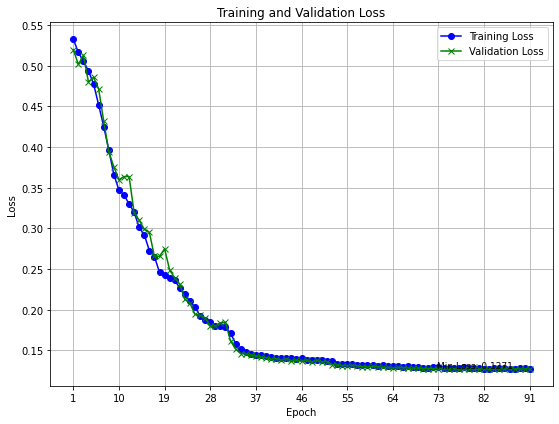

In [443]:
tf.get_logger().setLevel('ERROR')
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models()[0]

best_model_history = best_model.fit(
    train_ds_autotuned, 
    validation_data=val_ds_autotuned,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

best_model.save('best_rnn_model.keras') # Saving best model
plot_history(best_model_history)

In [444]:
best_model_loaded = load_model('best_rnn_model.keras') # Saving best model

for text in seed_texts:
    start_tokens = [word_to_index.get(_, 1) for _ in text.split()]
    generated_sentences = transformer_text_generator(start_tokens, best_model_loaded, max_tokens=20)
    print('-'*50)
    print(f"Input text: {text}")
    print(f"Generated text: {generated_sentences}")
    print('-'*50, '\n')

--------------------------------------------------
Input text: embrace each day
Generated text: brings a new day filled with endless possibilities .
-------------------------------------------------- 

--------------------------------------------------
Input text: radiate some
Generated text: story 's garden , for it is the only constant in life into reality .
-------------------------------------------------- 

--------------------------------------------------
Input text: believe that
Generated text: you will create a world becomes your canvas .
-------------------------------------------------- 

--------------------------------------------------
Input text: life's actual purpose is
Generated text: the fire that fuels your success .
-------------------------------------------------- 

--------------------------------------------------
Input text: dance through each and every
Generated text: moment into present moment that powers your journey .
---------------------------------------

| Criteria             | Score   |
|----------------------|---------|
| Relevance            | 6/10    |
| Coherence and Flow  | 6/10    |
| Grammar and Spelling| 6/10    |
| Consistency          | 10/10    |
| Originality          | 10/10   |
| Clarity              | 7/10    |
| **Total**              | **45/60**    |

## Further improvements

### Subword tokenization
Subword tokenization is a text processing method that breaks words into smaller units, such as characters or character sequences, to create a flexible vocabulary for encoding and decoding text. It is particularly useful for handling languages with complex word forms, dealing with out-of-vocabulary words, and compressing text efficiently. Common algorithms for subword tokenization include Byte-Pair Encoding (BPE), SentencePiece, and WordPiece.

#### BPE, WordPiece, or Sentence Piece?

BPE, WordPiece, and SentencePiece are subword tokenization techniques used in natural language processing. 

- BPE iteratively merges character or character pairs, is popular, but may not handle word boundaries well. 

- WordPiece, similar to BPE, treats spaces as tokens and is used in models like BERT. 

- SentencePiece is language-agnostic, adaptable, and suitable for various languages and custom vocabularies.

### NLP Metrics
You can’t train a good model if you don’t have the right evaluation metric, and you can’t explain your model if you don’t understand the metric you’re using. This task of generating text renders many commonly used evaluation metrics useless due to its nature. We want our models to come up with robust sentences, and not fixed to a "right answer". Thus metrics such as `accuracy`, `precision`, `recall`, `f1 score`, would not be useful even though classification is used. However there are other metrics that do fit the nature of text generation. **Perplexity**.

#### Perplexity
Perplexity calculates the confidence of a model to predict the next word. This metric works in this case because we want a variety of answers for the same prompts, but still be coheret. 

However, it is hard to make "apples-to-apples" comparisons across datasets with different context lengths, vocabulary sizes, words, character-based models, etc, because of how much it is affected by vocabulary size.

https://surge-ai.medium.com/evaluating-language-models-an-introduction-to-perplexity-in-nlp-f6019f7fb914

Other metrics such as BLEU are used for measuring a model's accuracy. Its use case is mainly on machine translation tasks
